ㄹ**Lab 7 : Node2Vec**
- Instuctor : Kijung Shin
- Teaching Assistants : Hyunju Lee(main), Deukryeol Yoon, Shinhwan Kang 
- 본 실습에서는 random walk 기반 network embedding 방법 중 하나인 node2vec 알고리즘을 사용하여 clustering, node classification과 같은 여러 downstream task들을 수행해본다.

* 학습 목표

> 1. node2vec library의 사용법을 익힌다.
2. node2vec embedding 벡터를 사용하여 여러 downstream tasks(clustering, node classification)를 수행하는 방법을 익힌다.




**Clustering with Node2Vec**


In [2]:
!pip install networkx
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.1-cp37-none-any.whl size=5734 sha256=7dec2e622a9f92e14adf1d70e9fc2ba91c857feee47458a4aeb471bb69bd95ee
  Stored in directory: /root/.cache/pip/wheels/b3/59/ea/22e964f74bb864c5423cf82027a4d69dd65bac0bbf95fd46f5
Successfully built node2vec


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os, sys 
from google.colab import drive 

### 해당 코드 실행 시 colab에서 실행중인 폴더의 /content/drive/My Drive가 구글 드라이브에 연결됨

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import networkx as nx
from node2vec import Node2Vec
from matplotlib import pyplot as plt

In [5]:
###################### Dataset Description ##########################
'''
    [Reference]
        title={The Network Data Repository with Interactive Graph Analytics and Visualization},
        author={Ryan A. Rossi and Nesreen K. Ahmed},
        booktitle={AAAI},
        url={http://networkrepository.com},
        year={2015}

'''
###### lesmis.mtx : <node 1> <node 2> <weight> ######################
###### weight : 레미제라블에 동시에 등장한 등장인물의 횟수 ##########
#####################################################################

'\n    [Reference]\n        title={The Network Data Repository with Interactive Graph Analytics and Visualization},\n        author={Ryan A. Rossi and Nesreen K. Ahmed},\n        booktitle={AAAI},\n        url={http://networkrepository.com},\n        year={2015}\n\n'

In [6]:
##### Weighted Graph Generation #####

weighted_edgelist=[]
with open('drive/MyDrive/data/lab/lab7/lesmis.mtx', 'r') as f:
    for line in f:
        l = line.strip().split()
        if l[0].isdigit() == False:
            continue
        weighted_edgelist.append((str(int(l[0])-1), str(int(l[1])-1), float(l[2])))


G = nx.Graph()
G.add_weighted_edges_from(weighted_edgelist)       

In [7]:
############################ Fill in Your Code ############################################

# edge 별 확률 계산(p, q에 따른 edge별 확률 계산) & random walk 생성 
node2vec = Node2Vec(G, dimensions=16, walk_length=4, num_walks=200, workers=4)      # p = 1, q = 1 as default
# node embedding 구하기
model = node2vec.fit(window=2, min_count=1, batch_words=4)

##############################################################################################

In [8]:
print("#### Embedding Vector of Node 2 ####")
print(model.wv['2'])

#### Embedding Vector of Node 2 ####
[ 0.33903828  0.43090862  0.17692237 -0.7939274   0.6491305  -0.2098503
 -1.0610273   1.1693543  -0.39267272 -0.3162759   0.612558    0.55325323
 -0.45061627 -0.967273   -0.6440434  -1.1614807 ]


In [9]:
##### Node 2와 가장 유사한 10개의 node를 출력 #####

print("#### Most Similar Nodes to Node 2")
model.wv.most_similar('2')  

#### Most Similar Nodes to Node 2


[('3', 0.9969054460525513),
 ('7', 0.994147539138794),
 ('6', 0.9938610792160034),
 ('5', 0.9913018941879272),
 ('4', 0.9906114339828491),
 ('8', 0.9898799657821655),
 ('9', 0.9890292882919312),
 ('1', 0.9867995977401733),
 ('0', 0.9864295125007629),
 ('13', 0.6862064003944397)]

In [10]:
from sklearn.cluster import KMeans
import numpy as np
from matplotlib import pyplot as plt

In [11]:
#### sklearn.cluster의 KMeans 알고리즘을 실행시키기 위해 node별 embedding 값을 array로 변환해준다 
#### 노드 번호에 해당하는 index에 embedding 값을 저장
vectors_array = np.zeros((len(G.nodes), 16))
for node in G.nodes:
    vectors_array[int(node)] = model.wv[node]

In [12]:
#### kmeans clustering 알고리즘 실행 ###

############### Fill in Your Code #############################

kmeans = KMeans(n_clusters=5, random_state=0).fit(vectors_array)

################################################################

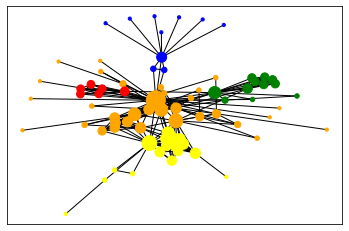

In [13]:


#### 그래프 시각화 - 각 클러스터별로 다른 색깔을 갖도록 함 ####
pos = nx.spring_layout(G)
node_color=[]
node_degree = []
for node in G.nodes:
    node_degree.append(G.degree[node]*10)
    i = int(node)
    if kmeans.labels_[i] == 0:
        node_color.append('red')
    elif kmeans.labels_[i] == 1:
        node_color.append('yellow')
    elif kmeans.labels_[i] == 2:
        node_color.append('blue')
    elif kmeans.labels_[i] == 3:
        node_color.append('green')
    else:
        node_color.append('orange')

img = nx.draw_networkx_nodes(G, pos, node_color = node_color, node_size=node_degree)
nx.draw_networkx_edges(G, pos)
plt.show()

**Node Classification**

In [14]:
###################### Dataset Description ##########################
##### cora.content : <paper_id> <word_attributes> <class_name> #####
##### cora.cites : <ID of cited paper> <ID of citing paper> #########
#####################################################################

In [15]:
# Directed Graph Generation 
# 메모리 활용을 위해 node class는 숫자로 re-labelling하여 사용

node_class = dict()
edgelist = list()
class_num = 1
class_name_to_num = dict()
with open('drive/MyDrive/data/lab/lab7/cora.content', 'r') as f, open('drive/MyDrive/data/lab/lab7/cora.cites','r') as f2:
    for line in f:
        l = line.strip().split()
        class_name = l[-1]
        if class_name not in class_name_to_num:
            class_name_to_num[class_name] = class_num
            class_num += 1
        node_class[l[0]] = class_name_to_num[class_name]

    for line in f2:
        l = line.strip().split()
        edgelist.append((l[1],l[0]))


G = nx.DiGraph()
G.add_edges_from(edgelist)


In [16]:
import time

In [17]:
s= time.time()
##### Node Embedding #####
node2vec = Node2Vec(G, dimensions=32, walk_length=50, num_walks=200, workers=4)  
model = node2vec.fit(window=10, min_count=1, batch_words=4) 
print("runtime: ", time.time() - s)


runtime:  684.6062746047974


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score


In [19]:
#### X : embedding of a node, y : class label of a node ####

X = list()
y = list()
node_name_to_idx = dict()
for i, (v, class_) in enumerate(node_class.items()):
    node_name_to_idx[v] = i
    X.append(model.wv[v])
    y.append(class_)
X = np.array(X)
y = np.array(y)

#################### Fill in Your Code ################################

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True)
clf = MLPClassifier(max_iter=500).fit(X_train, y_train)

#######################################################################


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [20]:
#################### Fill in Your Code ################################


y_predict = clf.predict(X_test)

######################################################################

print("###### Result of prediction #####")
print("Accuracy : {0:05.2f}% ".format(accuracy_score(y_test, y_predict)*100))

###### Result of prediction #####
Accuracy : 78.58% 


In [21]:
print("########## Comparison of Predicted and Test Results ######")
for i in range(len(y_test)//20):
    print("#########################################################")
    print("예측: ", y_predict[i*20:(i+1)*20])
    print("실제: ", y_test[i*20:(i+1)*20])

########## Comparison of Predicted and Test Results ######
#########################################################
예측:  [4 1 6 7 7 2 6 2 5 6 7 1 4 7 6 1 6 6 3 2]
실제:  [5 1 6 7 7 5 6 2 1 6 7 1 4 7 6 4 7 6 3 2]
#########################################################
예측:  [1 7 6 4 1 6 4 6 2 4 3 4 4 5 7 6 3 6 1 1]
실제:  [1 7 6 4 1 6 1 7 2 1 3 4 4 4 7 6 3 6 1 1]
#########################################################
예측:  [1 1 3 7 5 4 1 1 3 4 5 1 1 5 7 4 2 2 4 1]
실제:  [1 1 3 2 5 1 5 1 1 4 5 4 1 5 7 4 5 2 4 1]
#########################################################
예측:  [6 1 2 3 1 1 2 1 5 4 5 5 1 6 4 7 1 3 7 7]
실제:  [6 1 2 3 1 1 5 1 5 4 1 5 4 6 4 1 1 3 7 7]
#########################################################
예측:  [7 1 1 1 4 1 6 3 1 5 1 1 5 7 2 5 1 3 1 6]
실제:  [7 1 1 1 5 3 6 3 1 5 1 3 5 7 2 1 1 4 1 6]
#########################################################
예측:  [1 1 1 5 1 5 7 1 6 3 6 1 5 6 6 1 1 2 2 4]
실제:  [1 1 1 5 1 5 4 1 6 3 6 6 5 6 6 1 1 2 2 1]
#############################